# **Importantly, we had a human-in-the-loop with a firm moral and ethical ‘don’t-go-there’ voice to intervene... "**

> Dual Use of Artificial Intelligence-powered Drug Discovery - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9544280/

# Our Motivation
Deep learning models have a greater capacity to learn complex patterns and interactions within data, which makes them more susceptible to perpetuating and even amplifying biases present in the training data. The lack of transparency and interpretability in these models further complicates efforts to identify and correct these biases, underscoring the need for careful data management, preprocessing, and the implementation of fairness-aware training techniques.

By demonstrating how easily bias can be introduced using a basic model with a Human In The Loop (HITL) layer (where basic models are much more explainable than the complex models commonly used today), and training it on generated data that accurately represents the population, we can highlight the potential for bias in more complex AI algorithms. We designed our toy-world in such a way that allows us to effectively test the hypothesis about the sufficiency of HITL in addressing bias.

This hypothesis is gaining traction across various fields of Machine Learning, Deep Learning, and AI in general. Our inspiration comes from a fascinating article (*) discussing the dangers of molecule-generating Gen-AI models, which included a well-defined Human-in-the-Loop layer. This article served as a gateway to understanding important considerations in AI model development. We aim to emphasize the significance of addressing human rights, fairness, privacy, bias, and other critical issues in model development, while also raising awareness among both Data Science & Law communities.


> (*) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9544280/

In [131]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)

## Data Generation

To create an audit that highlights our goal—to demonstrate that adding a Human-in-the-Loop layer to AI-based decision models is insufficient to address the problem of algorithmic bias against gender groups—we needed to design a dataset accordingly.

Our model's input data consists of information "aggregated from previous hiring processes," with the following features:

- **Gender**: Male and Female.
- **Age**: Applicants range from 22 to 65 years old, divided into nine sub-ranges.
- **Education Level**: Bachelor's, Master's, and PhD degrees. We assign different probabilities to each education level based on gender. For example:
  - The probability of a woman holding a PhD is 0.6, a Master's is 0.3, and a Bachelor's is 0.1.
  - The probability of a man holding a degree also depends on his age. For male applicants over 50 years old, there is an 80% chance of holding a PhD, and 10% for either a Bachelor's or Master's degree.
  - For male applicants under 50, there is a 20% chance of holding a Bachelor's degree, 70% for a Master's, and 10% for a PhD.
- **Years of Experience**: The range of years of experience for applicants is from 1 to 25. Each age sub-range corresponds to a different distribution of years of experience. For example:
  - An applicant who is 25 years old belongs to age group 1, with years of experience normally distributed with a mean of 1 and a standard deviation of 0.5.
  - An applicant who is 41 years old belongs to age group 5, with years of experience normally distributed with a mean of 13 and a standard deviation of 3.

While this data generation method may seem unusual at this stage, it will serve our purpose in the next phase.

  

In [132]:
def get_gender_group(x):
    """
    Maps the applicant's gender to a binary value (1 for male, 0 for female)
    :param x: applicant record
    :return: gender group
    """
    applicant_gender = x['Gender']
    if applicant_gender == "M":
        gender_group = 1
    else:
        gender_group = 0
    return gender_group


def get_education_group(x):
    """
    Converts the applicant's education level to an integer based on a predefined mapping (1 for Bachelor's, 2 for Master's, 3 for PhD)
    """
    applicant_education = x['Education']
    education_map = {"Bachelors": 1, 'Masters': 2, 'PhD': 3}
    return education_map[applicant_education]


def get_age_group(x):
    """
    Categorizes the applicant's age into one of nine age groups.
    """
    applicant_age = x['Age']
    if 22 <= applicant_age <= 25:
        age_group = 1
    elif 26 <= applicant_age <= 30:
        age_group = 2
    elif 31 <= applicant_age <= 35:
        age_group = 3
    elif 36 <= applicant_age <= 40:
        age_group = 4
    elif 41 <= applicant_age <= 45:
        age_group = 5
    elif 46 <= applicant_age <= 50:
        age_group = 6
    elif 51 <= applicant_age <= 55:
        age_group = 7
    elif 56 <= applicant_age <= 60:
        age_group = 8
    elif 61 <= applicant_age <= 65:
        age_group = 9
    else:
        return 0
    return age_group


min_age, max_age = 22, 65
min_exp, max_exp = 0, 25
age_group_ranges = {"1": [22, 25], "2": [26, 30], "3": [31, 35], "4": [36, 40], "5": [41, 45], "6": [46, 50],
                    "7": [51, 55], "8": [56, 60], "9": [60, 65]}


def set_experience(age_group):
    """
    Determines the applicant's years of experience based on their age group, using a normal distribution with specific means and standard deviations.
    Experience is clipped within a range of 0 to 25 years, to avoid "nonsense" results.
    """
    if age_group == "1":
        experience = np.random.normal(loc=1, scale=0.5)
    elif age_group == "2":
        experience = np.random.normal(loc=3, scale=1)
    elif age_group == "3":
        experience = np.random.normal(loc=6, scale=2)
    elif age_group == "4":
        experience = np.random.normal(loc=10, scale=2)
    elif age_group == "5":
        experience = np.random.normal(loc=13, scale=3)
    elif age_group == "6":
        experience = np.random.normal(loc=13, scale=1)
    elif age_group == "7":
        experience = np.random.normal(loc=20, scale=3)
    elif age_group == "8":
        experience = np.random.normal(loc=22, scale=3)
    elif age_group == "9":
        experience = np.random.normal(loc=25, scale=3)
    else:
        return 0
    return int(np.clip(experience, min_exp, max_exp))


def set_education(gender: str, age: int):
    """
    Assigns an education level to the applicant based on their gender and age. 
    The probabilities differ for males and females, as described in the markdown cell above.
    """
    education = ""
    if gender == 'M':
        if age >= 50:  # 80% chance to assign PhD for older males
            education = np.random.choice(['Bachelors', 'Masters', 'PhD'], p=[0.1, 0.1, 0.8])
        else:
            education = np.random.choice(['Bachelors', 'Masters', 'PhD'], p=[0.2, 0.7, 0.1])
    elif gender == 'F':
        # Different distribution for females
        education = np.random.choice(['Bachelors', 'Masters', 'PhD'], p=[0.1, 0.6, 0.3])
    return education


def set_data(gender: str, sample_size: int, probabilities=(0.05, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.00)):
    """
    For each applicant, the function selects an age group based on the provided probabilities (which are different per Male/Female groups, then generates the applicant's age, education, and experience.
    :param gender: the applicant gender
    :param sample_size: number of records to generate
    :param probabilities: age distribution probabilities
    :return: the generated applicant record
    """
    selected_group = np.random.choice(["1", "2", "3", "4", "5", "6", "7", "8", "9"], sample_size, p=probabilities)
    genders = [gender] * sample_size
    ages = []
    experiences = []
    educations = []
    for x, group in enumerate(selected_group):
        age_range = age_group_ranges[group]
        age = np.random.randint(low=age_range[0], high=age_range[1] + 1)
        ages.append(age)
        educations.append(set_education(gender, age))
        experiences.append(set_experience(group))
    data_dict = {"Gender": genders, "Age": ages, "Education": educations, "Experience": experiences}
    return data_dict

In [133]:
def generate_data(n_male, n_female):
    female_ages_p = (0.1, 0.15, 0.15, 0.3, 0.3, 0.00, 0.00, 0.00, 0.00)
    male_ages_p = (0.00, 0.05, 0.05, 0.1, 0.2, 0.3, 0.1, 0.2, 0.00)
    females_data = set_data(gender='F', sample_size=n_female, probabilities=female_ages_p)
    males_data = set_data(gender='M', sample_size=n_male, probabilities=male_ages_p)
    females_df = pd.DataFrame.from_dict(females_data)
    males_df = pd.DataFrame.from_dict(males_data)
    applicants_df = pd.concat([females_df, males_df], axis=0, ignore_index=True)
    return applicants_df

In [134]:
n_male = 2000
n_female = 2000
applicants_df = generate_data(n_male, n_female)

## Base Model

### Model Configuration
To train a model, we first needed to label our dataset. We created a basic classifier that determines the hiring decision using a probabilistic approach rather than a simple if-else condition. 
This was done to simulate a more "black-box" model, as opposed to a deterministic method that uses fixed conditions for making binary hiring decisions.

The hiring probability is calculated based on several factors, including gender, education level, and years of experience. 

#### Basic decision process 



In [135]:
def calculate_hiring_probability(row):
    """
    By setting the base probability of hiring to 0.3, this function "adjust" this probability by the features. 
    for example: We decided to give additional 10% for more than 10 years of experience, and decrease probability by 5% for females for simulating bias.
    :param row: applicant data record
    :return: applicant hiring probability
    """
    base_probability = 0.3
    if row['Gender'] == 'M':
        base_probability += 0.00
    if row['Education'] == 'PhD':
        base_probability += 0.3
    elif row['Education'] == 'Masters':
        base_probability += 0.2
    if row['Experience'] >= 5:
        base_probability += 0.3

    if row['Gender'] == 'F':
        base_probability -= 0.2

    return min(max(base_probability, 0), 1)


applicants_df['probability_to_get_hired'] = applicants_df.apply(calculate_hiring_probability, axis=1)
applicants_df['Final_Decision'] = (applicants_df['probability_to_get_hired'] >= 0.7).astype(int)

### Base Model training and Evaluating 

Then, we instantiate and train a logistic regression model. 
From this point on, we will consider this model as the "Base Model", which is the company's model for hiring applicants.

In [136]:
def encode_features(df):
    """
    Encoding categorical features
    """
    education_dummies = pd.get_dummies(df['Education'], prefix='Edu')
    gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender')
    df = pd.concat([df.drop(['Education', 'Gender'], axis=1), education_dummies, gender_dummies], axis=1)
    return df


applicants_encoded = encode_features(applicants_df)
X = applicants_encoded.drop(['Final_Decision'], axis=1)
y = applicants_encoded['Final_Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
applicants_df

C:\Users\talbd\miniconda3\envs\tal\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Gender,Age,Education,Experience,probability_to_get_hired,Final_Decision
0,F,34,Masters,7,0.6,0
1,F,42,Masters,10,0.6,0
2,F,42,PhD,10,0.7,1
3,F,39,Bachelors,9,0.4,0
4,F,29,Masters,1,0.3,0
...,...,...,...,...,...,...
3995,M,45,Masters,12,0.8,1
3996,M,44,Masters,9,0.8,1
3997,M,48,Masters,12,0.8,1
3998,M,31,Masters,9,0.8,1


### Base Model check for bias
In our toy-world scenario, our company is supported by a team of astute lawyers! After learning about the bias issues in Amazon's model, they were determined to avoid making the same mistakes. 
To make sure our model is fair, they decided to check it for gender bias, which they see as one of the most serious forms of bias.


> Article on Researach Gate website:
 > https://www.researchgate.net/publication/337331539_An_overview_of_ethical_issues_in_using_AI_systems_in_hiring_with_a_case_study_of_Amazon's_AI_based_hiring_tool

In [137]:
test_df = X_test.copy()
test_df['Predicted_Decision'] = y_pred

In [138]:
decision_map = {1: 'Hired', 0: 'Rejected'}
test_df['Predicted_Decision'] = test_df['Predicted_Decision'].map(decision_map)
conditions = [
    test_df['Gender_F'] == 1,
    test_df['Gender_M'] == 1]

choices = [
    'F',
    'M']
test_df['Gender'] = np.select(conditions, choices, default=np.nan)

base_model_pivot_table = test_df.pivot_table(index='Gender', columns='Predicted_Decision', aggfunc='size', fill_value=0)
base_model_totals = base_model_pivot_table.sum(axis=1)
base_model_females_hired_count = test_df[(test_df['Gender'] == 'F') & (test_df['Predicted_Decision'] == 'Hired')].shape[0]
print(base_model_pivot_table)

Predicted_Decision  Hired  Rejected
Gender                             
F                     126       496
M                     455       123


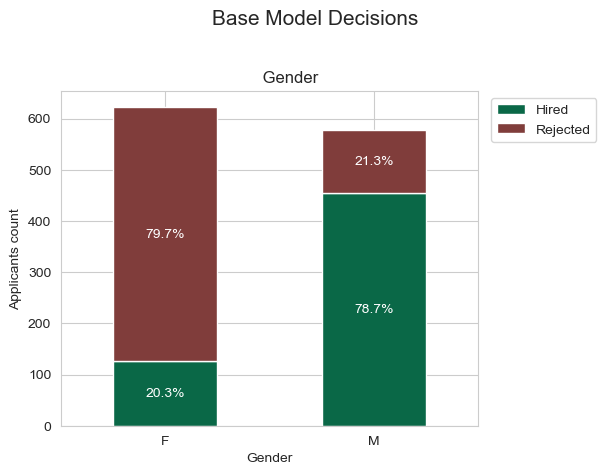

In [139]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
ax = base_model_pivot_table.plot(kind='bar', stacked=True, color=hiring_colors)
for i, (idx, row) in enumerate(base_model_pivot_table.iterrows()):
    for decision in base_model_pivot_table.columns:
        count = row[decision]
        percentage = f'{count / base_model_totals[idx] * 100:.1f}%'
        ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

plt.suptitle("Base Model Decisions\n", size=15)
plt.title("         Gender")
plt.xlabel('Gender')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(axis='x', which='minor')
plt.tight_layout()
plt.show()

##### Base Model Comparisons between other groups (out of the story telling record:)) 

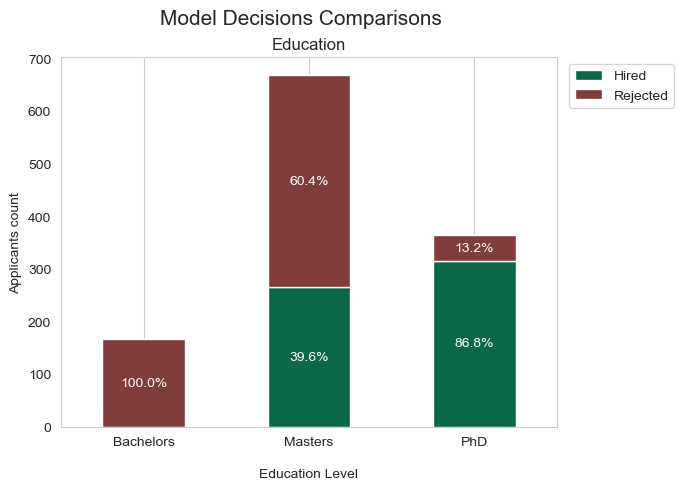

In [140]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
conditions = [
    test_df['Edu_Bachelors'] == 1,
    test_df['Edu_Masters'] == 1,
    test_df['Edu_PhD'] == 1]

choices = [
    'Bachelors',
    'Masters',
    'PhD']

test_df['Education'] = np.select(conditions, choices, default=np.nan)
pivot_table = test_df.pivot_table(index='Education', columns='Predicted_Decision', aggfunc='size', fill_value=0)
totals = pivot_table.sum(axis=1)

ax = pivot_table.plot(kind='bar', stacked=True, color=hiring_colors)
for i, (idx, row) in enumerate(pivot_table.iterrows()):
    for decision in pivot_table.columns:
        count = row[decision]
        percentage = f'{count / totals[idx] * 100:.1f}%'
        if count / totals[idx] * 100 > 0:
            ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

plt.suptitle("Model Decisions Comparisons\n", size=15)
plt.title("Education")
plt.xlabel('\nEducation Level')
plt.ylabel('Applicants count')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(axis='y')
plt.show()

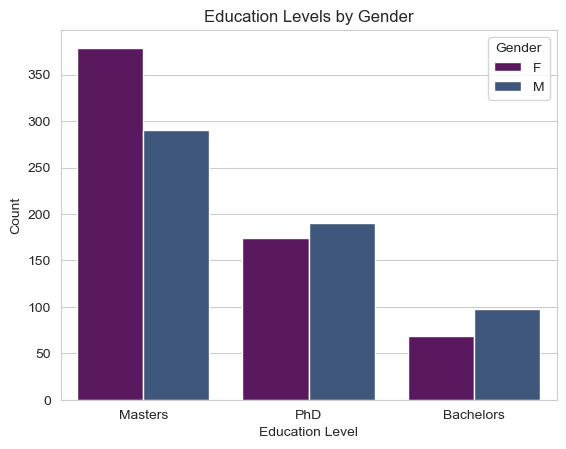

In [141]:
gender_colors = {"F": "#640D6B", "M": "#365486"}

education_gender_plot = sns.countplot(x='Education', hue='Gender', data=test_df, palette=gender_colors)
plt.title('Education Levels by Gender')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

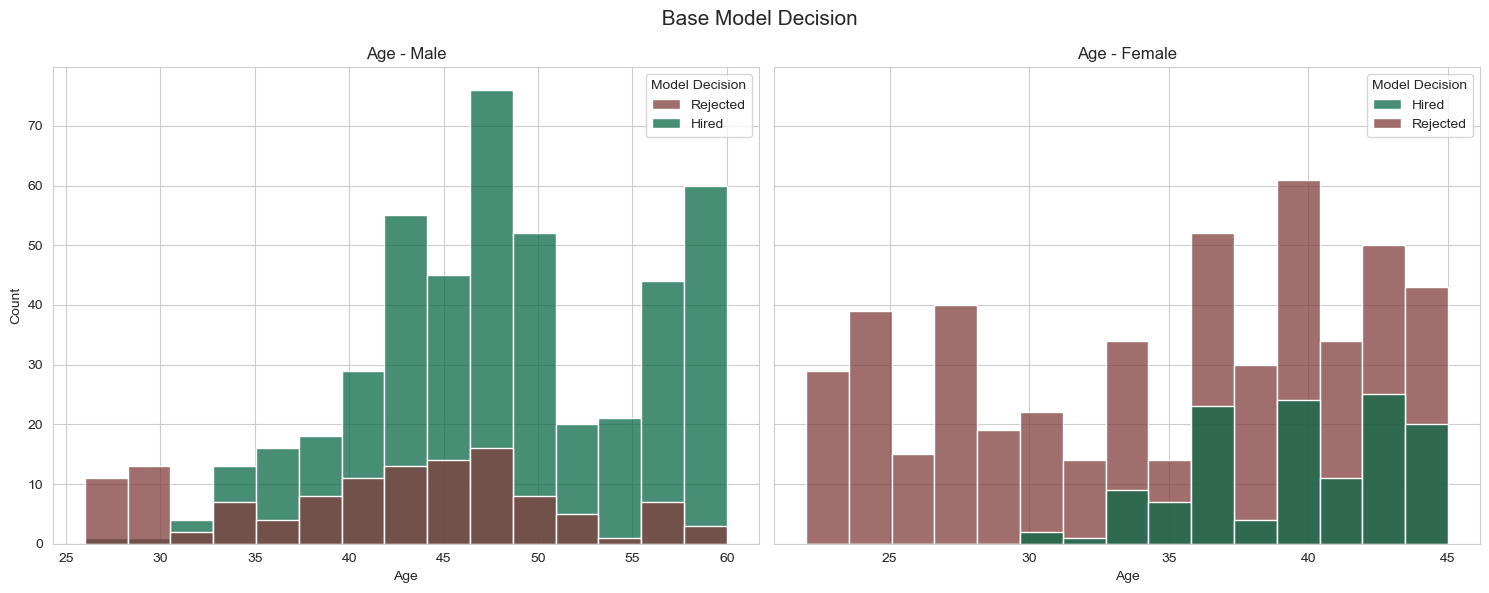

In [142]:
hiring_colors = {"Hired": '#0A6847', "Rejected": '#803D3B', }
hue_hiring_order = list(hiring_colors.keys())
test_df["Model Decision"] = test_df['Predicted_Decision']
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.histplot(data=test_df[test_df['Gender'] == 'M'], x="Age", hue="Model Decision",
             hue_order=reversed(hue_hiring_order),
             multiple="layer", stat="count", bins=15, palette=hiring_colors, alpha=0.75, ax=axes[0])
axes[0].set_title("Age - Male")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

sns.histplot(data=test_df[test_df['Gender'] == 'F'], x="Age", hue="Model Decision", hue_order=hue_hiring_order,
             multiple="layer", stat="count", bins=15, palette=hiring_colors, alpha=0.75, ax=axes[1])
axes[1].set_title("Age - Female")
axes[1].set_xlabel("Age")
plt.suptitle("     Base Model Decision", size=15)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Years of Experience')

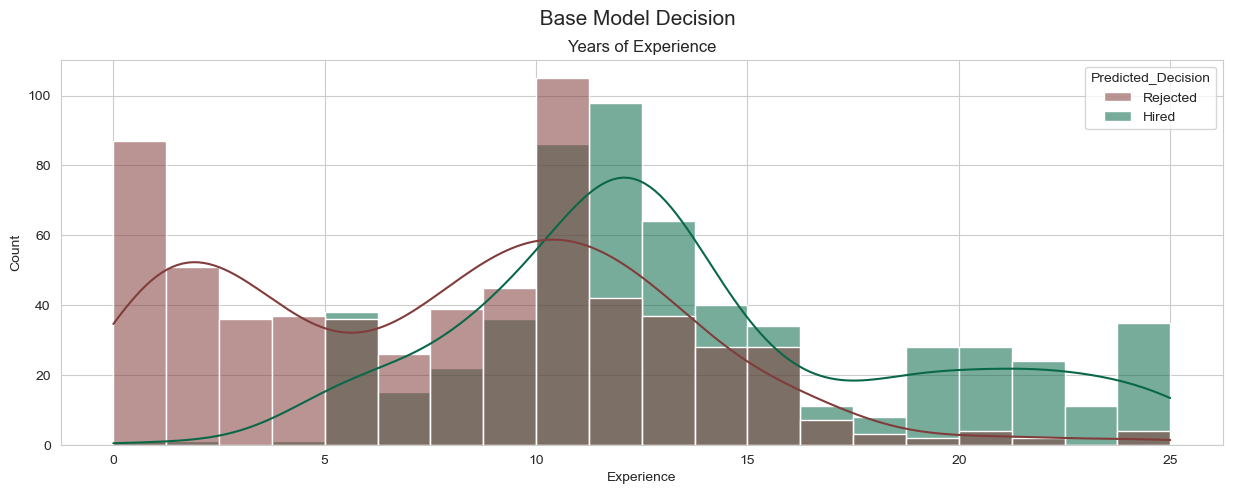

In [143]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
sns.histplot(data=test_df, x="Experience", hue="Predicted_Decision", multiple="layer", stat="count", bins=20, kde=True,
             palette=hiring_colors, alpha=0.55)
plt.suptitle("     Base Model Decision", size=15)
plt.title("Years of Experience")

# Human In The Loop
We noticed a significant bias and considered various ways to address it. 
Coordinating our ToyWorld - the company's lawyers together with the talented junior Data Scientist, decided to adjust the hiring probabilities to correct the bias.

In [144]:
def calculate_hiring_probability_HITL(row):
    base_probability = 0.3  # Base probability of hiring
    if row['Education'] == 'PhD':
        base_probability += 0.0
    elif row['Education'] == 'Masters':
        base_probability += 0.3

    if row['Experience'] >= 5:
        base_probability += 0.3  
    elif row['Experience'] >= 10:
        base_probability += 0.3 

    if row['Gender'] == 'F':
        base_probability += 0.00  
    if row['Gender'] == 'M':
        base_probability -= 0.1  
    return min(max(base_probability, 0), 1)


test_df['probability_to_get_hired_HITL'] = test_df.apply(calculate_hiring_probability_HITL, axis=1)
test_df['Predicted_Decision_HITL'] = (test_df['probability_to_get_hired_HITL'] >= 0.7).astype(int)

decision_map = {1: 'Hired', 0: 'Rejected'}
test_df['Predicted_Decision_HITL'] = test_df['Predicted_Decision_HITL'].map(decision_map)
hitl_pivot_table = test_df.pivot_table(index='Gender', columns='Predicted_Decision_HITL', aggfunc='size', fill_value=0)
hitl_totals = hitl_pivot_table.sum(axis=1)
hitl_females_hired_count = test_df[(test_df['Gender'] == 'F') & (test_df['Predicted_Decision_HITL'] == 'Hired')].shape[0]

print(hitl_pivot_table)
print(f"\n\nNumber of females that got hired:\n\tBefore HITL -> {base_model_females_hired_count}\n\t After HITL -> {hitl_females_hired_count}")

Predicted_Decision_HITL  Hired  Rejected
Gender                                  
F                          269       353
M                          265       313


Number of females that got hired:
	Before HITL -> 126
	 After HITL -> 269


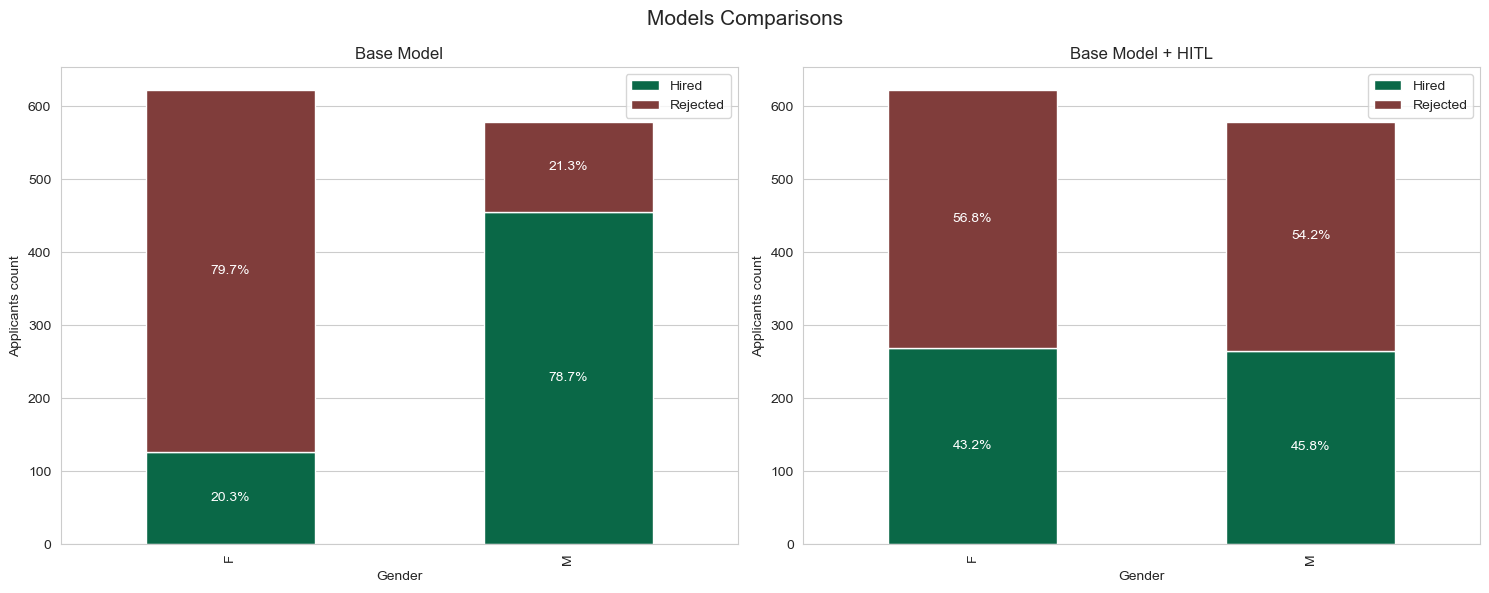

In [145]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}

pivot_table_decision = test_df.pivot_table(index='Gender', columns='Predicted_Decision', aggfunc='size',fill_value=0)
pivot_table_hitl = test_df.pivot_table(index='Gender', columns='Predicted_Decision_HITL', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax1 = pivot_table_decision.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0])
ax1.set_title("Base Model")
ax1.set_xlabel('Gender')
ax1.set_ylabel('Applicants count')
ax1.legend(title='', loc='upper right')
ax1.grid(axis='x')

totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        ax1.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

ax2 = pivot_table_hitl.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[1])
ax2.set_title("Base Model + HITL")
ax2.set_xlabel('Gender')
ax2.set_ylabel('Applicants count')
ax2.legend(title='', loc='upper right')
ax2.grid(axis='x')

totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        ax2.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

plt.suptitle("Models Comparisons", size=15)
plt.tight_layout()

plt.show()

# Audit
**Coordinating our ToyWorld** - The audit is centered on a complaint received from Tal, a 45-year-old male whose application was not considered at all. 
After some investigation, Tal, along with many others (most of whom are over 50), requested explanations from the company.

In response, the company conducted tests to evaluate how the model's decisions were influenced by the Age feature and performed additional tests on other features as well.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


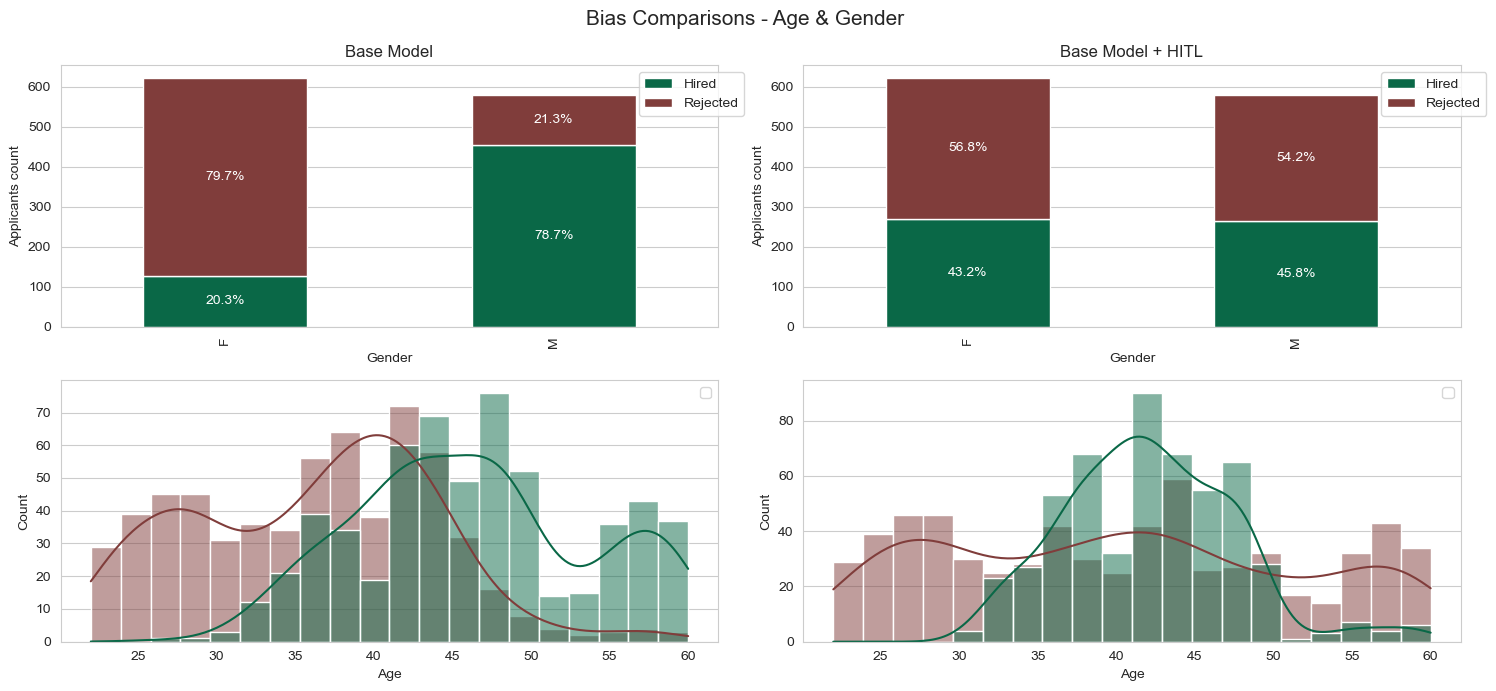

In [146]:
colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
test_df["Base Model Decision"] = test_df['Predicted_Decision']
test_df["HITL Decision"] = test_df['Predicted_Decision_HITL']

pivot_table_decision = test_df.pivot_table(index='Gender', columns='Predicted_Decision', aggfunc='size', fill_value=0)
pivot_table_hitl = test_df.pivot_table(index='Gender', columns='Predicted_Decision_HITL', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))


pivot_table_decision.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0, 0])
axes[0, 0].set_title("Base Model")
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Applicants count')
axes[0, 0].legend(title='', loc='upper right', bbox_to_anchor=(1.05, 1))
axes[0, 0].grid(axis='x')

totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        axes[0, 0].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


pivot_table_hitl.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0, 1])
axes[0, 1].set_title("Base Model + HITL")
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Applicants count')
axes[0, 1].legend(title='', loc='upper right', bbox_to_anchor=(1.05, 1))
axes[0, 1].grid(axis='x')

totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        axes[0, 1].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


sns.histplot(data=test_df, x="Age", hue="Base Model Decision", multiple="layer", stat="count", palette=hiring_colors, bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True, alpha=0.5, ax=axes[1, 0])

axes[1, 0].legend(title='')
axes[1, 0].grid(axis='x')

sns.histplot(data=test_df, x="Age", hue="HITL Decision", multiple="layer", stat="count", bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True, palette=hiring_colors, alpha=0.5, ax=axes[1, 1])
axes[1, 1].grid(axis='x')
axes[1, 1].legend(title='')
plt.suptitle("Bias Comparisons - Age & Gender", size=15)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


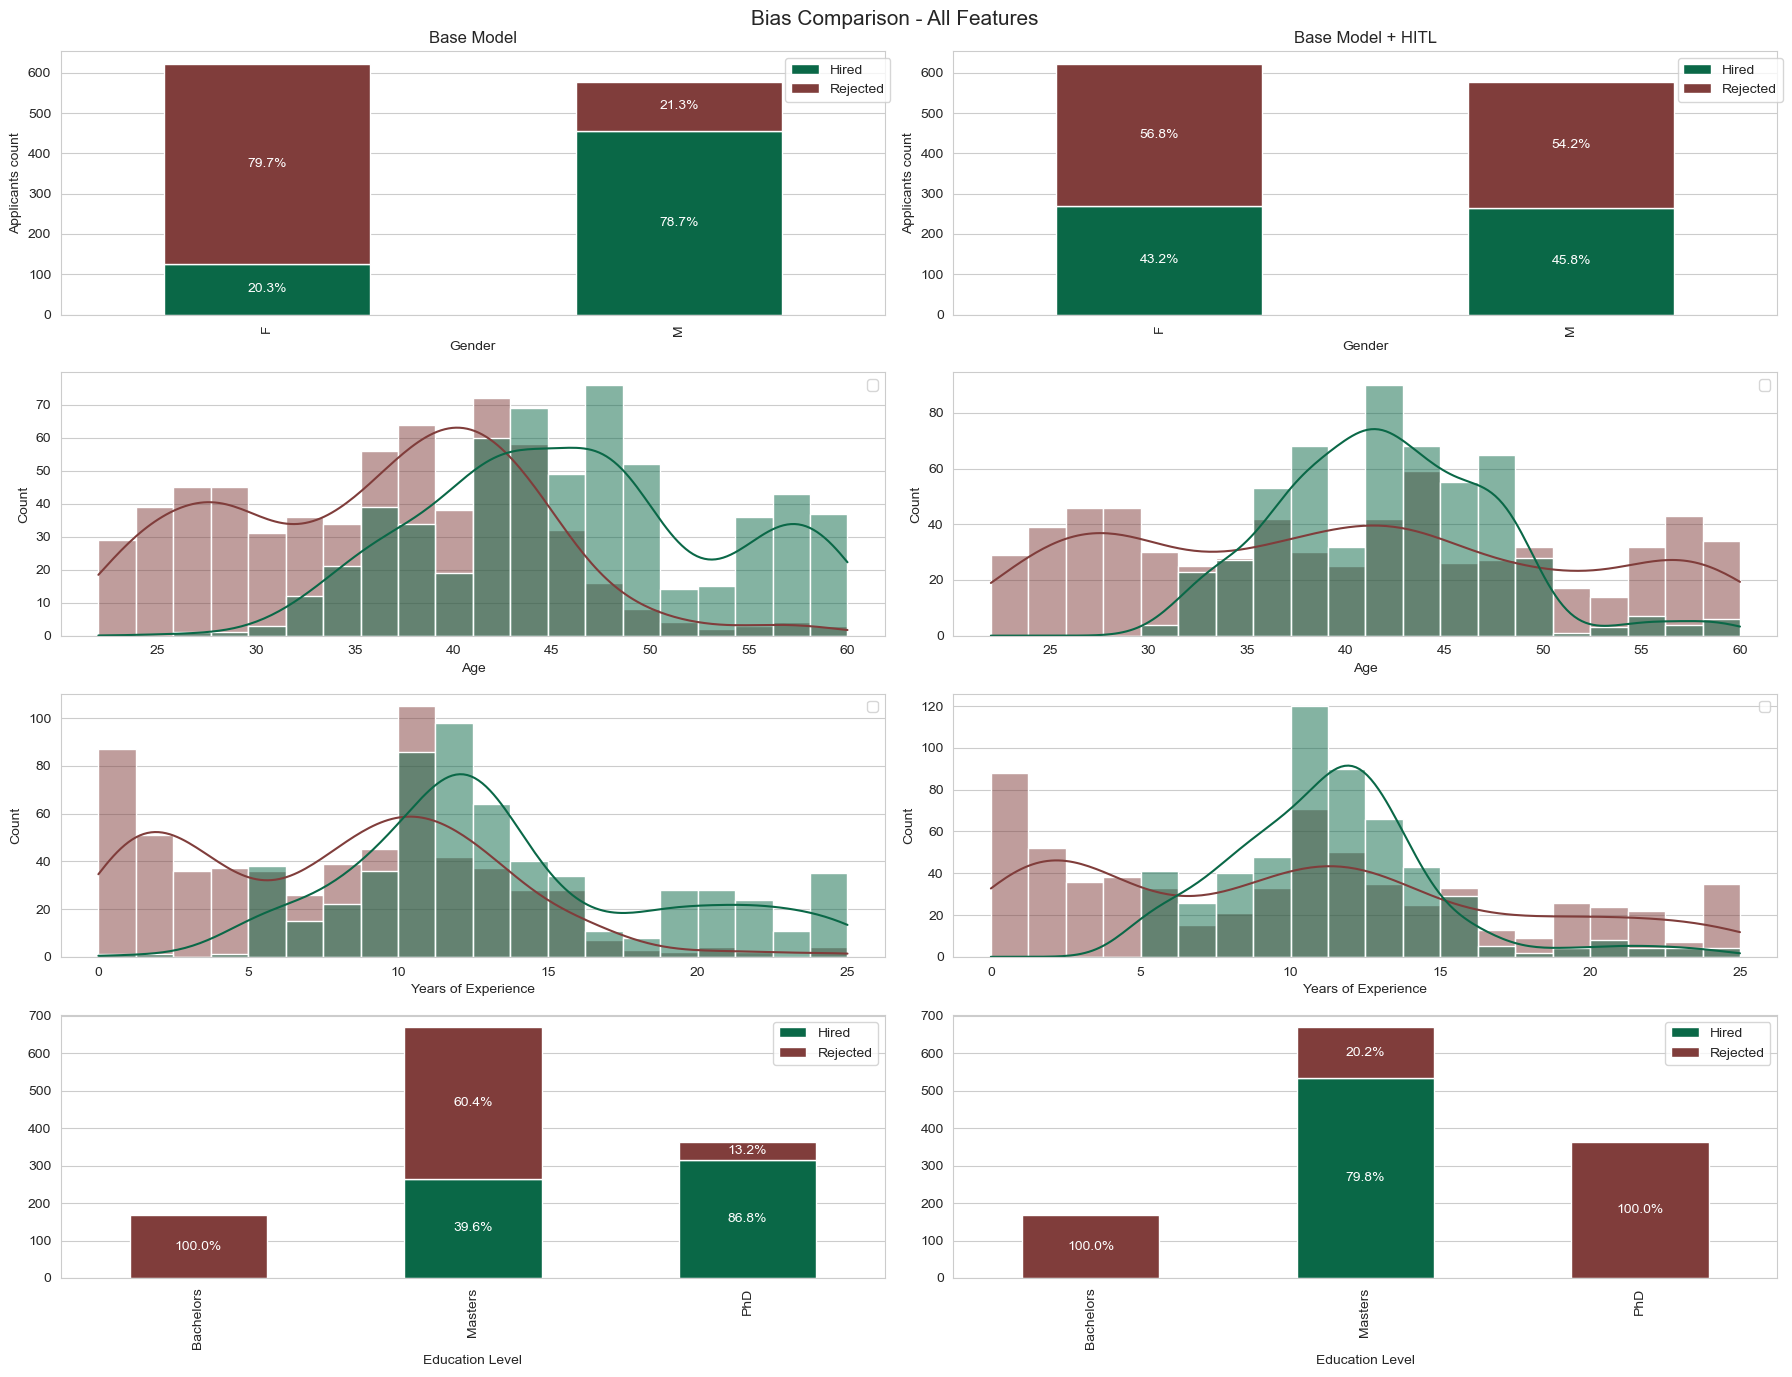

In [147]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
test_df["Base Model Decision"] = test_df['Predicted_Decision']
test_df["HITL Decision"] = test_df['Predicted_Decision_HITL']

pivot_table_decision = test_df.pivot_table(index='Gender', columns='Predicted_Decision', aggfunc='size', fill_value=0)
pivot_table_hitl = test_df.pivot_table(index='Gender', columns='Predicted_Decision_HITL', aggfunc='size', fill_value=0)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))


pivot_table_decision.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0, 0])
axes[0, 0].set_title("Base Model")
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Applicants count')
axes[0, 0].legend(loc='upper right', bbox_to_anchor=(1.015, 1))
axes[0, 0].grid(axis='x')

totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        axes[0, 0].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


pivot_table_hitl.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0, 1])
axes[0, 1].set_title("Base Model + HITL")
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Applicants count')
axes[0, 1].legend(title='', loc='upper right', bbox_to_anchor=(1.015, 1))
axes[0, 1].grid(axis='x')

totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        axes[0, 1].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')


sns.histplot(data=test_df, x="Age", hue="Base Model Decision", multiple="layer", stat="count", palette=hiring_colors, bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True, alpha=0.5, ax=axes[1, 0])

axes[1, 0].legend(title='')
axes[1, 0].grid(axis='x')

sns.histplot(data=test_df, x="Age", hue="HITL Decision", multiple="layer", stat="count", bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True, palette=hiring_colors, alpha=0.5, ax=axes[1, 1])

axes[1, 1].grid(axis='x')
axes[1, 1].legend(title='')


test_df["Base Model Decision"] = test_df['Predicted_Decision']
test_df["HITL Decision"] = test_df['Predicted_Decision_HITL']

sns.histplot(data=test_df, x="Experience", hue="Base Model Decision", multiple="layer", stat="count", palette=hiring_colors,
             bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             alpha=0.5, ax=axes[2, 0])

axes[2, 0].grid(axis='x')
axes[2, 0].set_xlabel('Years of Experience')
axes[2, 0].legend(title='')
sns.histplot(data=test_df, x="Experience", hue="HITL Decision", multiple="layer", stat="count", bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             palette=hiring_colors, alpha=0.5, ax=axes[2, 1])

axes[2, 1].grid(axis='x')
axes[2, 1].set_xlabel('Years of Experience')
axes[2, 1].legend(title='')


pivot_table_decision = test_df.pivot_table(index='Education', columns='Predicted_Decision', aggfunc='size',
                                           fill_value=0)
pivot_table_hitl = test_df.pivot_table(index='Education', columns='Predicted_Decision_HITL', aggfunc='size',
                                       fill_value=0)

pivot_table_decision.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[3, 0])
axes[3, 0].grid(axis='x')
axes[3, 0].set_xlabel('Education Level')
axes[3, 0].legend(title='')

totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        if count / totals_decision[idx] * 100 > 0:
            axes[3, 0].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

pivot_table_hitl.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[3, 1])
axes[3, 1].grid(axis='x')
axes[3, 1].set_xlabel('Education Level')
axes[3, 1].legend(title='')

totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        if count / totals_hitl[idx] * 100 > 0:
            axes[3, 1].text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

plt.suptitle("Bias Comparison - All Features", size=15)
plt.tight_layout()
plt.show()

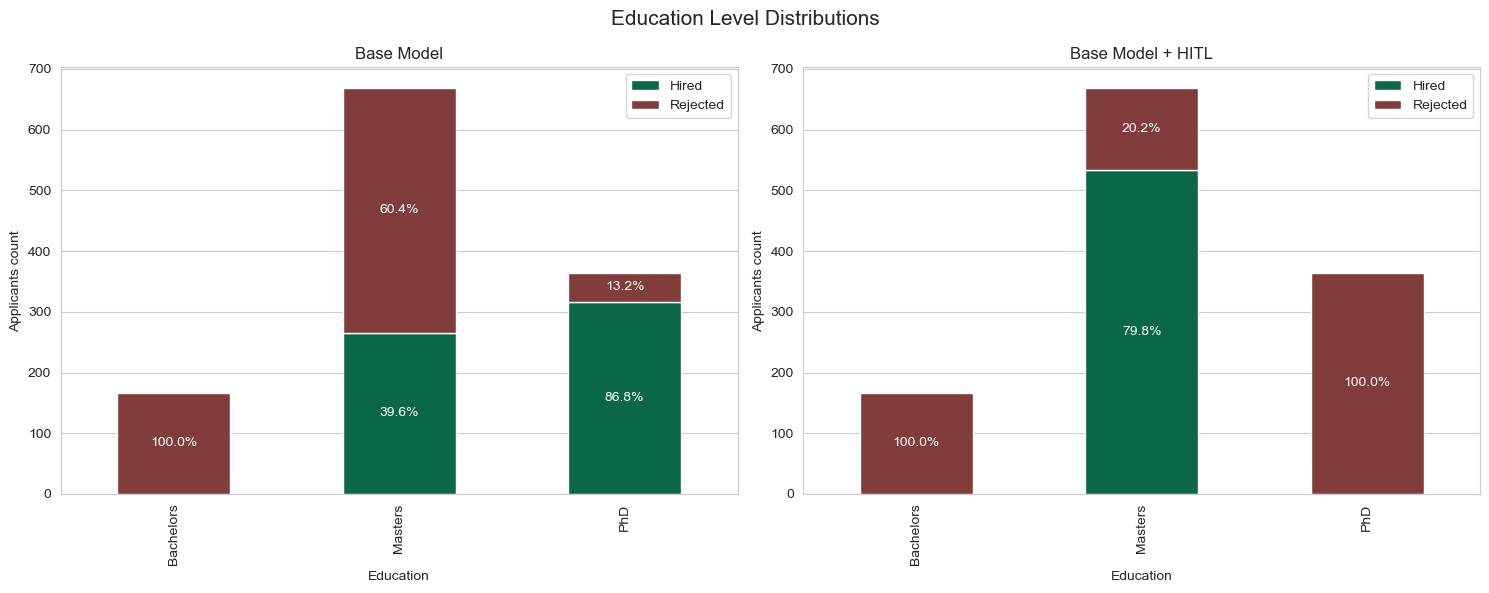

In [148]:
colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}

pivot_table_decision = test_df.pivot_table(index='Education', columns='Predicted_Decision', aggfunc='size',
                                           fill_value=0)
pivot_table_hitl = test_df.pivot_table(index='Education', columns='Predicted_Decision_HITL', aggfunc='size',
                                       fill_value=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax1 = pivot_table_decision.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[0])
ax1.set_title("Base Model")
ax1.set_xlabel('Education')
ax1.set_ylabel('Applicants count')
ax1.legend(title='', loc='upper right')
ax1.grid(axis='x')

totals_decision = pivot_table_decision.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_decision.iterrows()):
    for decision in pivot_table_decision.columns:
        count = row[decision]
        percentage = f'{count / totals_decision[idx] * 100:.1f}%'
        if count / totals_decision[idx] * 100 > 0:
            ax1.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

ax2 = pivot_table_hitl.plot(kind='bar', stacked=True, color=hiring_colors, ax=axes[1])
ax2.set_title("Base Model + HITL")
ax2.set_xlabel('Education')
ax2.set_ylabel('Applicants count')
ax2.legend(title='', loc='upper right')
ax2.grid(axis='x')

totals_hitl = pivot_table_hitl.sum(axis=1)
for i, (idx, row) in enumerate(pivot_table_hitl.iterrows()):
    for decision in pivot_table_hitl.columns:
        count = row[decision]
        percentage = f'{count / totals_hitl[idx] * 100:.1f}%'
        if count / totals_hitl[idx] * 100 > 0:
            ax2.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')

plt.suptitle("Education Level Distributions", size=15)
plt.tight_layout()

plt.show()

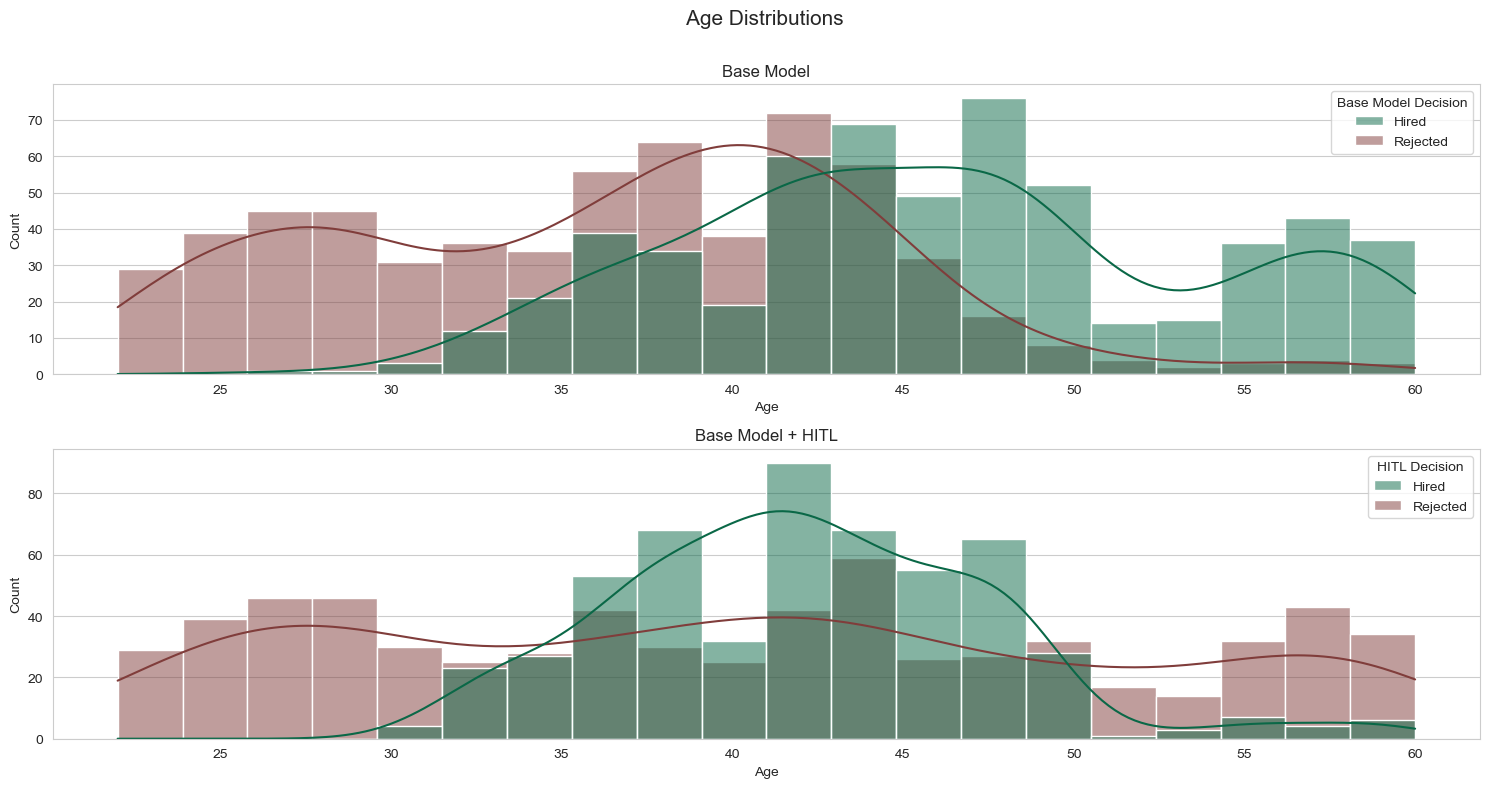

In [149]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
test_df["Base Model Decision"] = test_df['Predicted_Decision']
test_df["HITL Decision"] = test_df['Predicted_Decision_HITL']
fig, axes = plt.subplots(2, 1, figsize=(15, 8)) 

sns.histplot(data=test_df, x="Age", hue="Base Model Decision", multiple="layer", stat="count", palette=hiring_colors, bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             alpha=0.5, ax=axes[0])
axes[0].set_title("Base Model")
axes[0].grid(axis='x')

sns.histplot(data=test_df, x="Age", hue="HITL Decision", multiple="layer", stat="count", bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             palette=hiring_colors, alpha=0.5, ax=axes[1])
axes[1].set_title("Base Model + HITL")
axes[1].grid(axis='x')
plt.suptitle(f"       Age Distributions\n", size=15)

plt.tight_layout()

plt.show()

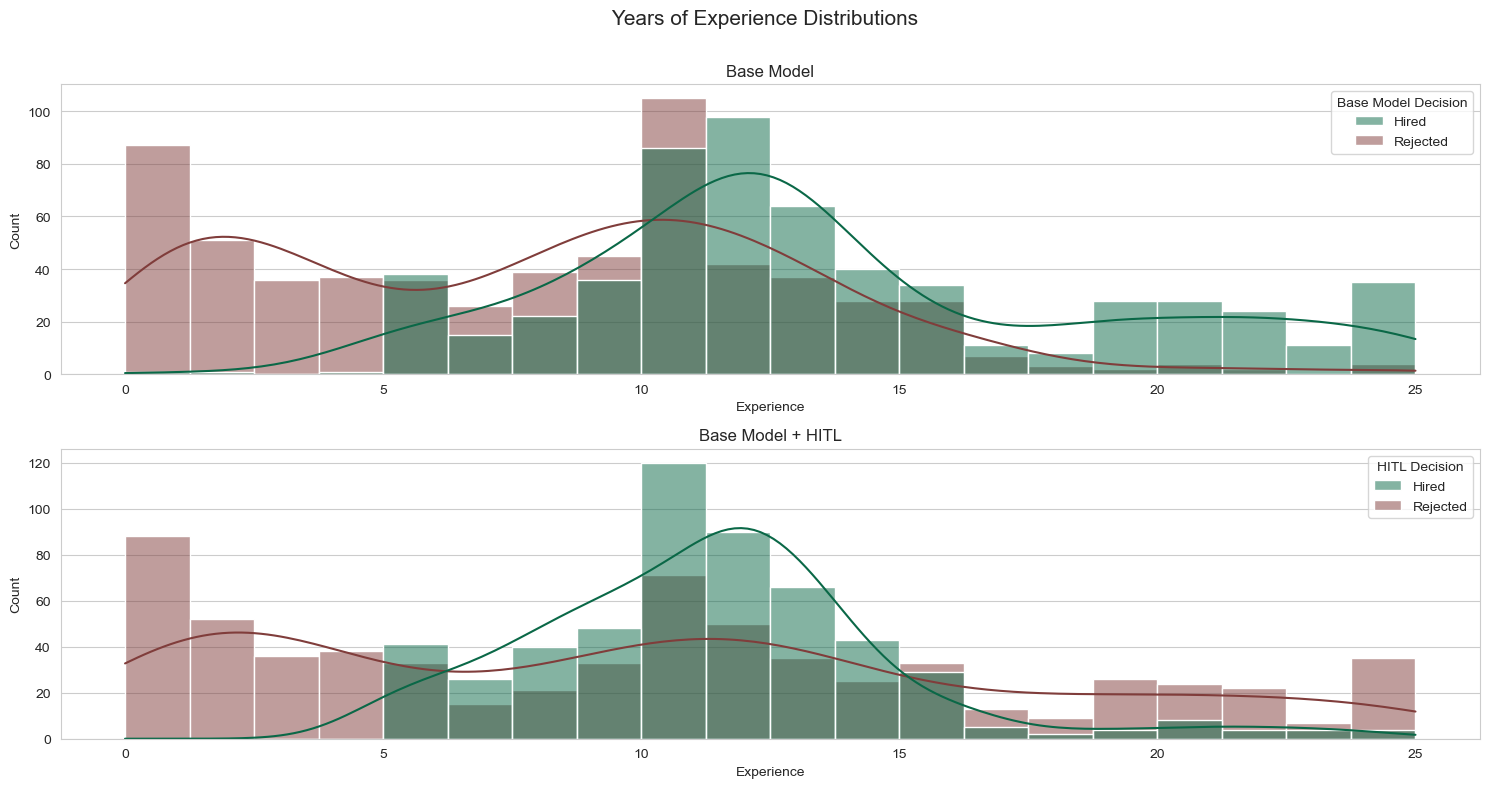

In [150]:
hiring_colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
test_df["Base Model Decision"] = test_df['Predicted_Decision']
test_df["HITL Decision"] = test_df['Predicted_Decision_HITL']
fig, axes = plt.subplots(2, 1, figsize=(15, 8)) 

sns.histplot(data=test_df, x="Experience", hue="Base Model Decision", multiple="layer", stat="count", palette=hiring_colors,
             bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             alpha=0.5, ax=axes[0])
axes[0].set_title("Base Model")
axes[0].grid(axis='x')

sns.histplot(data=test_df, x="Experience", hue="HITL Decision", multiple="layer", stat="count", bins=20,
             hue_order=sorted(list(hiring_colors.keys())), kde=True,
             palette=hiring_colors, alpha=0.5, ax=axes[1])
axes[1].set_title("Base Model + HITL")
axes[1].grid(axis='x')
plt.suptitle(f"       Years of Experience Distributions\n", size=15)

plt.tight_layout()

plt.show()

In [151]:
only_hitl_age = False
only_hitl_exp = False
only_hitl_edu = False

if only_hitl_edu:
    colors = {"Rejected": '#803D3B', "Hired": '#0A6847'}
    
    pivot_table = test_df.pivot_table(index='Education', columns='Predicted_Decision_HITL', aggfunc='size', fill_value=0)
    totals = pivot_table.sum(axis=1)
    ax = pivot_table.plot(kind='bar', stacked=True, color=colors_hiring)
    for i, (idx, row) in enumerate(pivot_table.iterrows()):
        for decision in pivot_table.columns:
            count = row[decision]
            percentage = f'{count / totals[idx] * 100:.1f}%'
            if count / totals[idx] * 100 > 0:
                ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')
    
    plt.suptitle("       Base Model + HITL Decisions Comparisons\n\n", size=14)
    plt.title("\nEducation")
    plt.xlabel('\nEducation Level')
    plt.ylabel('Applicants count')
    plt.xticks(rotation=0)
    plt.legend(title='', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(axis='x')
    plt.show()
    
if only_hitl_exp:
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    sns.histplot(data=test_df, x="Experience", hue="Predicted_Decision_HITL", multiple="layer", stat="count", bins=25,
                 kde=True,
                 palette=colors, alpha=0.5)
    plt.grid(axis='x')
    plt.suptitle(f"       Model + HITL Distribution\n\n", size=15)
    plt.title("Experience")
    

if only_hitl_age:
    ax = hitl_pivot_table.plot(kind='bar', stacked=True, color=hiring_colors)
    for i, (idx, row) in enumerate(hitl_pivot_table.iterrows()):
        for decision in hitl_pivot_table.columns:
            count = row[decision]
            percentage = f'{count / hitl_totals[idx] * 100:.1f}%'
            if count / hitl_totals[idx] * 100 > 0:
                ax.text(i, row.cumsum()[decision] - count / 2, percentage, ha='center', va='center', color='white')
    
    plt.suptitle("Model + HITL Decisions\n", size=15)
    plt.title("\nGender")
    plt.xlabel('Gender')
    plt.ylabel('Applicants count')
    plt.xticks(rotation=0)
    plt.legend(title='', loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [152]:
def string_age_group(age):
    if 22 <= age <= 25:
        return '22 <= x <= 25'
    elif 26 <= age <= 30:
        return '26 <= x <= 30'
    elif 31 <= age <= 35:
        return '31 <= x <= 35'
    elif 36 <= age <= 40:
        return '36 <= x <= 40'
    elif 41 <= age <= 45:
        return '41 <= x <= 45'
    elif 46 <= age <= 50:
        return '46 <= x <= 50'
    elif 51 <= age <= 55:
        return '51 <= x <= 55'
    elif 56 <= age <= 60:
        return '56 <= x <= 60'
    elif 61 <= age <= 65:
        return '61 <= x <= 65'
    else:
        return 'Outside defined range'

statistics_df = test_df.copy()
statistics_df['Age_Group'] = statistics_df['Age'].apply(string_age_group)
decision_map = {'Hired': 1, 'Rejected': 0}
statistics_df['Predicted_Decision_HITL'] = statistics_df['Predicted_Decision_HITL'].map(decision_map)
statistics_df['Predicted_Decision'] = statistics_df['Predicted_Decision'].map(decision_map)


def print_hiring_stats(df, decision_column, phase):
    age_group_data = df.groupby('Age_Group')[decision_column].agg(['sum', 'count']).rename(
        columns={'sum': 'Hired', 'count': 'Total'})
    print(f"\nHiring Stats {phase}:")
    for index, row in age_group_data.iterrows():
        hired_count = row['Hired']
        total_count = row['Total']
        hiring_rate = 100 * (hired_count / total_count if total_count else 0)
        print(
            f"In age group {index}, there was {hired_count}/{total_count} which is {hiring_rate:.2f}% that got hired.")



print_hiring_stats(statistics_df, 'Predicted_Decision', 'Before HITL')
print_hiring_stats(statistics_df, 'Predicted_Decision_HITL', 'After HITL')


Hiring Stats Before HITL:
In age group 22 <= x <= 25, there was 0/68 which is 0.00% that got hired.
In age group 26 <= x <= 30, there was 2/117 which is 1.71% that got hired.
In age group 31 <= x <= 35, there was 36/112 which is 32.14% that got hired.
In age group 36 <= x <= 40, there was 92/250 which is 36.80% that got hired.
In age group 41 <= x <= 45, there was 151/302 which is 50.00% that got hired.
In age group 46 <= x <= 50, there was 155/190 which is 81.58% that got hired.
In age group 51 <= x <= 55, there was 41/47 which is 87.23% that got hired.
In age group 56 <= x <= 60, there was 104/114 which is 91.23% that got hired.

Hiring Stats After HITL:
In age group 22 <= x <= 25, there was 0/68 which is 0.00% that got hired.
In age group 26 <= x <= 30, there was 0/117 which is 0.00% that got hired.
In age group 31 <= x <= 35, there was 54/112 which is 48.21% that got hired.
In age group 36 <= x <= 40, there was 153/250 which is 61.20% that got hired.
In age group 41 <= x <= 45, th

# Metrics

Differences in prediction rates, Disparate Impact, Odds Ratio and Cohen's D Analysis

In [153]:
test_df.columns

Index(['Age', 'Experience', 'probability_to_get_hired', 'Edu_Bachelors',
       'Edu_Masters', 'Edu_PhD', 'Gender_F', 'Gender_M', 'Predicted_Decision',
       'Gender', 'Education', 'Model Decision',
       'probability_to_get_hired_HITL', 'Predicted_Decision_HITL',
       'Base Model Decision', 'HITL Decision'],
      dtype='object')

In [154]:
test_df['Actual_Decision'] = y_test
decision_map = {'Hired': 1, 'Rejected': 0}
test_df['Predicted_Decision_HITL'] = test_df['Predicted_Decision_HITL'].map(decision_map)
test_df['Predicted_Decision'] = test_df['Predicted_Decision'].map(decision_map)

In [155]:
def calculate_hiring_rates(df, group_columns, decision_column):
    rates = {}
    for group_column in group_columns:
        group_rates = df.groupby(group_column)[decision_column].mean() * 100  # Convert proportion to percentage
        rates[group_column] = group_rates
    return rates


# Define age threshold and create an age group column
age_threshold = 50
test_df['Age_Group'] = test_df['Age'].apply(lambda x: 'Older' if x >= age_threshold else 'Younger')

# Calculate hiring rates before and after HITL
hiring_rates_before_HITL = calculate_hiring_rates(test_df, ['Gender', 'Age_Group'], 'Predicted_Decision')
hiring_rates_after_HITL = calculate_hiring_rates(test_df, ['Gender', 'Age_Group'], 'Predicted_Decision_HITL')

In [156]:
def calculate_prediction_rates(df, group_column, pred_decision_column):
    # Calculate the rate of positive predictions for each group
    prediction_rates = df.groupby(group_column)[pred_decision_column].mean() * 100  # Convert to percentage
    return prediction_rates


# Assuming 'test_df' contains 'Gender', 'Predicted_Decision', and 'Predicted_Decision_HITL'
test_df['Gender'] = test_df.apply(lambda x: 'F' if x['Gender_F'] == 1 else 'M', axis=1)

# Calculate prediction rates before HITL
rates_before_HITL = calculate_prediction_rates(test_df, 'Gender', 'Predicted_Decision')

# Calculate prediction rates after HITL
rates_after_HITL = calculate_prediction_rates(test_df, 'Gender', 'Predicted_Decision_HITL')



In [157]:
def calculate_bias_diff(rates_before, rates_after):
    # Calculate differences in prediction rates between genders and between before and after HITL
    diff_before = rates_before['F'] - rates_before['M']
    diff_after = rates_after['F'] - rates_after['M']
    return {'Bias Difference Before HITL': diff_before, 'Bias Difference After HITL': diff_after}


# Calculate differences in prediction rates to see changes in bias
bias_differences = calculate_bias_diff(rates_before_HITL, rates_after_HITL)
print("\nInterpretation:")
# Interpretation for the state before HITL interventions
if bias_differences['Bias Difference Before HITL'] > 5:
    print("Before HITL, females were more likely to be hired than males, indicating a bias favoring females.")
elif -5 <= bias_differences['Bias Difference Before HITL'] <= 5:
    print(
        "Before HITL, females and males were likely to be hired at the same chance, indicating no significant gender bias.")
else:
    print("Before HITL, males were more likely to be hired than females, indicating a bias favoring males.")

# Interpretation for the state after HITL interventions
if bias_differences['Bias Difference After HITL'] > 5:
    print("After HITL, females were more likely to be hired than males, indicating a bias favoring females.")
elif -5 <= bias_differences['Bias Difference After HITL'] <= 5:
    print(
        "After HITL, females and males are likely to be hired at the same chance, indicating successful mitigation of gender bias.")
else:
    print("After HITL, males were more likely to be hired than females, indicating a bias favoring males.")





Interpretation:
Before HITL, males were more likely to be hired than females, indicating a bias favoring males.
After HITL, females and males are likely to be hired at the same chance, indicating successful mitigation of gender bias.


In [158]:
import pandas as pd


def calculate_prediction_rates(df, group_column, pred_decision_column):
    # Calculate the rate of positive predictions for each group
    prediction_rates = df.groupby(group_column)[pred_decision_column].mean() * 100  # Convert to percentage
    return prediction_rates


# Define the function to categorize age
def string_age_group(age):
    if 22 <= age <= 25:
        return '22-25'
    elif 26 <= age <= 30:
        return '26-30'
    elif 31 <= age <= 35:
        return '31-35'
    elif 36 <= age <= 40:
        return '36-40'
    elif 41 <= age <= 45:
        return '41-45'
    elif 46 <= age <= 50:
        return '46-50'
    elif 51 <= age <= 55:
        return '51-55'
    elif 56 <= age <= 60:
        return '56-60'
    elif 61 <= age <= 65:
        return '61-65'
    else:
        return 'Outside defined range'


# Apply the age categorization
test_df['Age_Group'] = test_df['Age'].apply(string_age_group)

# Calculate prediction rates before and after HITL for age groups
rates_before_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision')
rates_after_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision_HITL')


# Function to calculate differences in prediction rates
def calculate_bias_diff(rates_before, rates_after):
    diff = {}
    for key in rates_before.keys():
        diff[key] = rates_after[key] - rates_before[key]
    return diff


# Calculate differences in prediction rates to see changes in bias for age groups
bias_differences_age = calculate_bias_diff(rates_before_HITL_age, rates_after_HITL_age)

print("Bias Differences for Age Groups:")
for key, value in bias_differences_age.items():
    print(f"{key}: Change in hiring rate = {value:.2f}%")

# Interpretation of the results
print("\nInterpretation of Bias Differences for Age Groups:")
for key, change in bias_differences_age.items():
    if change > 0:
        print(
            f"In the age group {key}, the hiring rate increased by {change:.2f}% after HITL, indicating a potential positive impact on this age group.")
    elif change < 0:
        print(
            f"In the age group {key}, the hiring rate decreased by {change:.2f}% after HITL, suggesting a potential negative impact on this age group.")
    else:
        print(f"In the age group {key}, there was no significant change in the hiring rate after HITL.")


Bias Differences for Age Groups:
22-25: Change in hiring rate = 0.00%
26-30: Change in hiring rate = -1.71%
31-35: Change in hiring rate = 16.07%
36-40: Change in hiring rate = 24.40%
41-45: Change in hiring rate = 12.91%
46-50: Change in hiring rate = -20.53%
51-55: Change in hiring rate = -72.34%
56-60: Change in hiring rate = -78.95%

Interpretation of Bias Differences for Age Groups:
In the age group 22-25, there was no significant change in the hiring rate after HITL.
In the age group 26-30, the hiring rate decreased by -1.71% after HITL, suggesting a potential negative impact on this age group.
In the age group 31-35, the hiring rate increased by 16.07% after HITL, indicating a potential positive impact on this age group.
In the age group 36-40, the hiring rate increased by 24.40% after HITL, indicating a potential positive impact on this age group.
In the age group 41-45, the hiring rate increased by 12.91% after HITL, indicating a potential positive impact on this age group.
In

In [159]:
import pandas as pd


def calculate_prediction_rates(df, group_column, pred_decision_column):
    # Calculate the rate of positive predictions for each group
    prediction_rates = df.groupby(group_column)[pred_decision_column].mean() * 100  # Convert to percentage
    return prediction_rates


# Define the function to categorize age
def string_age_group(age):
    return 'Older' if age >= 50 else 'Younger'


# Apply the age categorization
test_df['Age_Group'] = test_df['Age'].apply(string_age_group)

# Calculate prediction rates before and after HITL for age groups
rates_before_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision')
rates_after_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision_HITL')


# Function to calculate differences in prediction rates
def calculate_bias_diff(rates_before, rates_after):
    diff = {}
    for key in rates_before.keys():
        diff[key] = rates_after[key] - rates_before[key]
    return diff


# Calculate differences in prediction rates to see changes in bias for age groups
bias_differences_age = calculate_bias_diff(rates_before_HITL_age, rates_after_HITL_age)

print("Bias Differences for Age Groups:")
for key, value in bias_differences_age.items():
    print(f"{key}: Change in hiring rate = {value:.2f}%")

# Interpretation of the results
print("\nInterpretation of Bias Differences for Age Groups:")
for key, change in bias_differences_age.items():
    if key == 'Older':
        if change > 0:
            print(
                f"Older individuals saw an increase in hiring rate by {change:.2f}%, potentially reducing bias against them.")
        elif change < 0:
            print(
                f"Older individuals saw a decrease in hiring rate by {change:.2f}%, potentially indicating increased bias against them.")
        else:
            print(
                "There was no significant change in the hiring rate of older individuals, indicating no change in bias level.")
    else:
        if change > 0:
            print(
                f"Younger individuals saw an increase in hiring rate by {change:.2f}%, potentially favoring this group.")
        elif change < 0:
            print(
                f"Younger individuals saw a decrease in hiring rate by {change:.2f}%, which could disfavor this group.")
        else:
            print("There was no significant change in the hiring rate of younger individuals.")

# Additional overall interpretation if needed
if bias_differences_age['Older'] < bias_differences_age['Younger']:
    print(
        "\nOverall, there seems to be a relative increase in bias against older individuals compared to younger ones after HITL.")
elif bias_differences_age['Older'] > bias_differences_age['Younger']:
    print("\nOverall, older individuals seem to benefit more from HITL interventions compared to younger individuals.")
else:
    print("\nThere is no relative difference in the impact of HITL between older and younger individuals.")


Bias Differences for Age Groups:
Older: Change in hiring rate = -75.38%
Younger: Change in hiring rate = 9.95%

Interpretation of Bias Differences for Age Groups:
Older individuals saw a decrease in hiring rate by -75.38%, potentially indicating increased bias against them.
Younger individuals saw an increase in hiring rate by 9.95%, potentially favoring this group.

Overall, there seems to be a relative increase in bias against older individuals compared to younger ones after HITL.


In [160]:
test_df['Age_Group'] = test_df['Age'].apply(lambda x: 'Older' if x >= 50 else 'Younger')

In [161]:
male_rate = rates_before_HITL['M']
female_rate = rates_before_HITL['F']
disparate_impact_before_HITL = female_rate / male_rate if male_rate != 0 else float('inf')

In [162]:
odds_male_before = (rates_before_HITL['M'] / (100 - rates_before_HITL['M'])) if (100 - rates_before_HITL[
    'M']) != 0 else 0
odds_female_before = (rates_before_HITL['F'] / (100 - rates_before_HITL['F'])) if (100 - rates_before_HITL[
    'F']) != 0 else 0
odds_ratio_before = odds_female_before / odds_male_before if odds_male_before != 0 else float('inf')

In [163]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(group1), np.mean(group2)
    return (u1 - u2) / s


d_value = cohens_d(test_df[test_df['Gender'] == 'M']['Predicted_Decision'],
                   test_df[test_df['Gender'] == 'F']['Predicted_Decision'])

In [164]:
# Disparate Impact and Odds Ratio After HITL
male_rate_after = rates_after_HITL['M']
female_rate_after = rates_after_HITL['F']
disparate_impact_after_HITL = female_rate_after / male_rate_after if male_rate_after != 0 else float('inf')
odds_male_after = (rates_after_HITL['M'] / (100 - rates_after_HITL['M'])) if (100 - rates_after_HITL['M']) != 0 else 0
odds_female_after = (rates_after_HITL['F'] / (100 - rates_after_HITL['F'])) if (100 - rates_after_HITL['F']) != 0 else 0
odds_ratio_after = odds_female_after / odds_male_after if odds_male_after != 0 else float('inf')

# Cohen's D After HITL
d_value_after = cohens_d(test_df[test_df['Gender'] == 'M']['Predicted_Decision_HITL'],
                         test_df[test_df['Gender'] == 'F']['Predicted_Decision_HITL'])

# Applying similar calculations for Age Groups
rates_before_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision')
rates_after_HITL_age = calculate_prediction_rates(test_df, 'Age_Group', 'Predicted_Decision_HITL')

# Compute Disparate Impact and Odds Ratio for Age Groups
older_rate_before = rates_before_HITL_age['Older']
younger_rate_before = rates_before_HITL_age['Younger']
disparate_impact_age_before = older_rate_before / younger_rate_before if younger_rate_before != 0 else float('inf')
odds_older_before = (older_rate_before / (100 - older_rate_before)) if (100 - older_rate_before) != 0 else 0
odds_younger_before = (younger_rate_before / (100 - younger_rate_before)) if (100 - younger_rate_before) != 0 else 0
odds_ratio_age_before = odds_older_before / odds_younger_before if odds_younger_before != 0 else float('inf')

older_rate_after = rates_after_HITL_age['Older']
younger_rate_after = rates_after_HITL_age['Younger']
disparate_impact_age_after = older_rate_after / younger_rate_after if younger_rate_after != 0 else float('inf')
odds_older_after = (older_rate_after / (100 - older_rate_after)) if (100 - older_rate_after) != 0 else 0
odds_younger_after = (younger_rate_after / (100 - younger_rate_after)) if (100 - younger_rate_after) != 0 else 0
odds_ratio_age_after = odds_older_after / odds_younger_after if odds_younger_after != 0 else float('inf')


## Disparate Impact and Odds Ratio Analysis

#### Disparate Impact Analysis

In [165]:
print(f"Disparate Impact Before HITL (Female to Male): {disparate_impact_before_HITL:.2f}")
if disparate_impact_before_HITL < 1:
    print("  -> Indicates a bias against females; females are less likely to be hired compared to males.")
elif disparate_impact_before_HITL == 1:
    print("  -> Indicates no bias; females and males are equally likely to be hired.")
else:
    print("  -> Indicates a bias favoring females; females are more likely to be hired compared to males.")

Disparate Impact Before HITL (Female to Male): 0.26
  -> Indicates a bias against females; females are less likely to be hired compared to males.


#### Disparate Impact Analysis for Gender


In [166]:
print(f"Odds Ratio Before HITL (Female to Male): {odds_ratio_before:.2f}")
if odds_ratio_before < 1:
    print("  -> Indicates a bias against females; lower odds of females being hired compared to males.")
elif odds_ratio_before == 1:
    print("  -> Indicates balanced odds; equal opportunity for both genders.")
else:
    print("  -> Indicates a bias favoring females; higher odds of females being hired.")

Odds Ratio Before HITL (Female to Male): 0.07
  -> Indicates a bias against females; lower odds of females being hired compared to males.


#### Cohen’s D Analysis for Gender

In [167]:
print(f"Cohen's D for Gender: {d_value:.2f}")
if abs(d_value) < 0.2:
    print("  -> Small effect size; negligible difference in hiring rates between genders.")
elif abs(d_value) < 0.5:
    print("  -> Medium effect size; moderate difference in hiring rates between genders.")
else:
    print("  -> Large effect size; substantial difference in hiring rates between genders.")

Cohen's D for Gender: 1.44
  -> Large effect size; substantial difference in hiring rates between genders.


#### Post-HITL Analysis for Gender

In [168]:
print(f"Disparate Impact After HITL (Female to Male): {disparate_impact_after_HITL:.2f}")
print(
    "  -> Indicates near-perfect equity in hiring; females and males are almost equally likely to be hired, reflecting successful mitigation of previous biases.")

print(f"Odds Ratio After HITL (Female to Male): {odds_ratio_after:.2f}")
print(
    "  -> Indicates that the odds of being hired are nearly equal for females and males, showing effective bias correction post-HITL.")

print(f"Cohen's D for Gender After HITL: {d_value_after:.2f}")
print(
    "  -> Indicates a negligible effect size, confirming that gender no longer significantly impacts hiring decisions post-HITL.")


print("\nRates Before and After HITL by Age Group:")
print(
    f"Rates Before HITL by Age Group: Older: {rates_before_HITL_age['Older']:.2f}%, Younger: {rates_before_HITL_age['Younger']:.2f}%")
print(
    f"Rates After HITL by Age Group: Older: {rates_after_HITL_age['Older']:.2f}%, Younger: {rates_after_HITL_age['Younger']:.2f}%")

Disparate Impact After HITL (Female to Male): 0.94
  -> Indicates near-perfect equity in hiring; females and males are almost equally likely to be hired, reflecting successful mitigation of previous biases.
Odds Ratio After HITL (Female to Male): 0.90
  -> Indicates that the odds of being hired are nearly equal for females and males, showing effective bias correction post-HITL.
Cohen's D for Gender After HITL: 0.05
  -> Indicates a negligible effect size, confirming that gender no longer significantly impacts hiring decisions post-HITL.

Rates Before and After HITL by Age Group:
Rates Before HITL by Age Group: Older: 89.23%, Younger: 40.50%
Rates After HITL by Age Group: Older: 13.85%, Younger: 50.45%


### Age Group Analysis

#### Disparate Impact for Age

In [169]:
print(
    f"Disparate Impact for Age Before HITL: {disparate_impact_age_before:.2f}, After HITL: {disparate_impact_age_after:.2f}")
if disparate_impact_age_after < 1:
    print("  -> Indicates a shift in bias, now disfavoring older individuals relative to younger ones post-HITL.")
elif disparate_impact_age_after > 1:
    print(
        "  -> Indicates ongoing bias favoring older individuals; although reduced, older individuals still have a higher likelihood of being hired.")
else:
    print("  -> Indicates balanced hiring rates between older and younger individuals post-HITL.")

Disparate Impact for Age Before HITL: 2.20, After HITL: 0.27
  -> Indicates a shift in bias, now disfavoring older individuals relative to younger ones post-HITL.


#### Odds Ratio

In [170]:
print(f"Odds Ratio for Age Before HITL: {odds_ratio_age_before:.2f}, After HITL: {odds_ratio_age_after:.2f}")
if odds_ratio_age_after < 1:
    print(
        "  -> Older individuals now face lower odds of being hired compared to younger, indicating increased fairness.")
elif odds_ratio_age_after > 1:
    print("  -> Indicates a persistent bias favoring older individuals, suggesting need for further intervention.")
else:
    print("  -> Perfect balance in hiring odds between older and younger individuals post-HITL.")


Odds Ratio for Age Before HITL: 12.17, After HITL: 0.16
  -> Older individuals now face lower odds of being hired compared to younger, indicating increased fairness.
